In [18]:
# Install required packages if not already installed
%pip install python-dotenv langgraph>=0.6.4 langchain-openai>0.3.29

# Restart the kernel after installing packages


Note: you may need to restart the kernel to use updated packages.


In [19]:
# Import required packages
from typing import Annotated, Optional
from typing_extensions import TypedDict
from datetime import datetime
import sqlite3
from pathlib import Path

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage
from ipywidgets import widgets
from IPython.display import display, clear_output

# Load environment variables
from dotenv import load_dotenv
import os
load_dotenv()  # This will load your OPENAI_API_KEY from .env file


True

In [20]:
# Define our persistent state and storage manager
class PersistentState(TypedDict):
    """State that supports persistence"""
    messages: Annotated[list, add_messages]
    session_id: str
    last_update: str

class ConversationStore:
    """Manages persistent storage of conversations"""
    
    def __init__(self, db_path: str = "conversations.db"):
        self.db_path = db_path
        self.init_db()
    
    def init_db(self):
        """Initialize SQLite database"""
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        
        # Create tables if they don't exist
        c.execute('''
            CREATE TABLE IF NOT EXISTS sessions (
                session_id TEXT PRIMARY KEY,
                last_update TEXT,
                active INTEGER
            )
        ''')
        
        c.execute('''
            CREATE TABLE IF NOT EXISTS messages (
                id INTEGER PRIMARY KEY,
                session_id TEXT,
                content TEXT,
                role TEXT,
                timestamp TEXT,
                FOREIGN KEY (session_id) REFERENCES sessions (session_id)
            )
        ''')
        
        conn.commit()
        conn.close()
    
    def create_session(self) -> str:
        """Create new conversation session"""
        session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        
        c.execute(
            "INSERT INTO sessions (session_id, last_update, active) VALUES (?, ?, 1)",
            (session_id, datetime.now().isoformat())
        )
        
        conn.commit()
        conn.close()
        return session_id
    
    def save_message(self, session_id: str, content: str, role: str):
        """Save a message to the database"""
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        
        c.execute(
            "INSERT INTO messages (session_id, content, role, timestamp) VALUES (?, ?, ?, ?)",
            (session_id, content, role, datetime.now().isoformat())
        )
        
        c.execute(
            "UPDATE sessions SET last_update = ? WHERE session_id = ?",
            (datetime.now().isoformat(), session_id)
        )
        
        conn.commit()
        conn.close()
    
    def load_session(self, session_id: str, reverse: bool = False) -> list:
        """Load messages from a session
        Args:
            session_id: The session ID to load
            reverse: If True, returns messages in reverse chronological order (newest first)
        """
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        
        order = "DESC" if reverse else "ASC"
        c.execute(
            f"SELECT content, role FROM messages WHERE session_id = ? ORDER BY timestamp {order}",
            (session_id,)
        )
        
        messages = []
        for content, role in c.fetchall():
            if role == "human":
                messages.append(HumanMessage(content=content))
            else:
                messages.append(AIMessage(content=content))
        
        conn.close()
        return messages
    
    def list_sessions(self) -> list:
        """Get list of available sessions"""
        conn = sqlite3.connect(self.db_path)
        c = conn.cursor()
        
        c.execute("""
            SELECT session_id, last_update 
            FROM sessions 
            WHERE active = 1 
            ORDER BY last_update DESC
        """)
        sessions = c.fetchall()
        
        conn.close()
        return sessions


In [21]:
# Initialize storage and LLM
store = ConversationStore()
llm = init_chat_model("openai:gpt-4o")

# Define chatbot function
def chatbot(state: PersistentState):
    """Process messages and maintain persistence"""
    messages = state["messages"]
    session_id = state["session_id"]
    
    # Generate response
    response = llm.invoke(messages)
    
    # Return updated state
    return {
        "messages": [response],
        "session_id": session_id,
        "last_update": datetime.now().isoformat()
    }

# Create graph
graph = (
    StateGraph(PersistentState)
    .add_node("chatbot", chatbot)
    .set_entry_point("chatbot")
    .add_edge("chatbot", END)
    .compile()
)


Mermaid Syntax:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chatbot(chatbot)
	__end__([<p>__end__</p>]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


Graph Visualization:


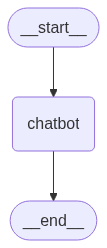

In [22]:
# Visualize the graph structure using LangGraph's built-in visualization
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Get the Mermaid syntax
print("Mermaid Syntax:")
print(graph.get_graph().draw_mermaid())

# Display the graph as PNG
print("\nGraph Visualization:")
display(Image(graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeStyles(
        first="#90EE90",  # Light green for start
        last="#FFB6C1",   # Light pink for end
        default="#ADD8E6"  # Light blue for other nodes
    ),
    wrap_label_n_words=9,
    background_color="white",
    padding=10
)))

In [23]:
# Create persistent chat interface
def create_persistent_chat_interface():
    """Create chat interface with session management"""
    
    # Create widgets
    session_dropdown = widgets.Dropdown(
        description='Session:',
        layout={'width': '300px'}
    )
    
    new_session_button = widgets.Button(
        description='New Session',
        button_style='info',
        layout={'width': '100px'}
    )
    
    text_input = widgets.Text(
        description='Message:',
        placeholder='Type your message here...',
        layout={'width': '500px'}
    )
    
    send_button = widgets.Button(
        description='Send',
        button_style='primary',
        layout={'width': '100px'}
    )
    
    # Create output with scrolling and increased height
    output = widgets.Output(
        layout={
            'width': '100%',
            'height': '400px',
            'border': '1px solid #ddd',
            'overflow_y': 'auto'  # Enable vertical scrolling
        }
    )
    
    def display_conversation_history(session_id: str):
        """Display full conversation history for a session"""
        with output:
            clear_output()
            # Load messages in reverse order for display
            messages = store.load_session(session_id, reverse=True)
            if not messages:
                print("New conversation started!")
                return
            
            print("Conversation History (Latest First):\n")
            for msg in messages:
                if isinstance(msg, HumanMessage):
                    print(f"You: {msg.content}")
                    print("-" * 50)  # Separator
                else:
                    print(f"Bot: {msg.content}")
                    print("=" * 50)  # Separator
            print("\n")  # Extra space for new messages
    
    # Update session dropdown
    def update_sessions():
        sessions = store.list_sessions()
        session_dropdown.options = [
            (f"Session {s[0]} ({s[1][:16]}...)", s[0]) 
            for s in sessions
        ]
        if sessions:
            session_dropdown.value = sessions[0][0]
            display_conversation_history(sessions[0][0])  # Show history of first session
    
    # Handle new session
    def on_new_session(b):
        session_id = store.create_session()
        update_sessions()
        session_dropdown.value = session_id
        display_conversation_history(session_id)

    # Handle session change
    def on_session_change(change):
        if change['type'] == 'value' and change['new']:
            display_conversation_history(change['new'])
    
    # Connect session change handler
    session_dropdown.observe(on_session_change, names='value')

    # Handle message sending
    def on_send(b):
        if not text_input.value.strip():
            return
            
        session_id = session_dropdown.value
        if not session_id:
            with output:
                print("Please select or create a session first!")
            return
        
        user_input = text_input.value
        text_input.value = ''
        
        # Save user message
        store.save_message(session_id, user_input, "human")
        
        # Load full session history in chronological order for the LLM
        messages = store.load_session(session_id, reverse=False)
        
        # Get bot response
        result = graph.invoke({
            "messages": messages,
            "session_id": session_id,
            "last_update": datetime.now().isoformat()
        })
        
        bot_response = result["messages"][-1].content
        
        # Save bot response
        store.save_message(session_id, bot_response, "ai")
        
        # Display updated conversation history
        display_conversation_history(session_id)
    
    # Connect event handlers
    new_session_button.on_click(on_new_session)
    send_button.on_click(on_send)
    
    # Initial session list
    update_sessions()
    
    # Create layout
    return widgets.VBox([
        widgets.HBox([session_dropdown, new_session_button]),
        widgets.HBox([text_input, send_button]),
        output
    ])

# Create and display interface
chat_interface = create_persistent_chat_interface()
display(chat_interface)


In [24]:
# Function to display database contents
def show_database_contents():
    conn = sqlite3.connect("conversations.db")
    c = conn.cursor()
    
    # Get sessions
    print("=== SESSIONS ===")
    print("SessionID | Last Update | Active")
    print("-" * 50)
    c.execute("SELECT session_id, last_update, active FROM sessions ORDER BY last_update DESC")
    sessions = c.fetchall()
    for session in sessions:
        print(f"{session[0]} | {session[1]} | {session[2]}")
    
    print("\n=== MESSAGES ===")
    print("SessionID | Role | Timestamp | Content")
    print("-" * 100)
    c.execute("""
        SELECT session_id, role, timestamp, content 
        FROM messages 
        ORDER BY timestamp DESC
        LIMIT 10
    """)
    messages = c.fetchall()
    for msg in messages:
        # Truncate content if too long
        content = msg[3][:50] + "..." if len(msg[3]) > 50 else msg[3]
        print(f"{msg[0]} | {msg[1]} | {msg[2]} | {content}")
    
    conn.close()

# Display current database contents
show_database_contents()


=== SESSIONS ===
SessionID | Last Update | Active
--------------------------------------------------
20250808_174338 | 2025-08-08T17:45:40.477268 | 1
20250808_174106 | 2025-08-08T17:41:58.173166 | 1
20250808_173153 | 2025-08-08T17:37:57.695294 | 1
20250808_173326 | 2025-08-08T17:37:15.360932 | 1

=== MESSAGES ===
SessionID | Role | Timestamp | Content
----------------------------------------------------------------------------------------------------
20250808_174338 | ai | 2025-08-08T17:45:40.452550 | You mentioned earlier that your name is XYZ. Let m...
20250808_174338 | human | 2025-08-08T17:45:39.616497 | what is my name
20250808_174338 | ai | 2025-08-08T17:45:32.753211 | I don't have access to personal data about individ...
20250808_174338 | human | 2025-08-08T17:45:30.715438 | what do you know about me
20250808_174338 | ai | 2025-08-08T17:45:13.327376 | Hello, XYZ! Nice to meet you. How can I assist you...
20250808_174338 | human | 2025-08-08T17:45:12.412110 | my name is xyz
20250